In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [27]:
REBUILD_DATA = True
 
    
class Dvc():
    IMG_SIZE = 50
    CATS = 'PetImages/Cat'
    DOGS = 'PetImages/Dog'
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for file in tqdm(os.listdir(label)):
                try:
                    # print(label)
                    path = os.path.join(label, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
            
            np.random.shuffle(self.training_data)
            np.save('training_data.npy', self.training_data)
            print("cat: ", self.catcount)
            print("dog: ", self.dogcount)
            

if REBUILD_DATA:
    dogvcat = Dvc()
    dogvcat.make_training_data()

PetImages/Cat


100%|███████████████████████████████████| 12501/12501 [00:11<00:00, 1123.14it/s]
/home/siddharth/.local/lib/python3.10/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


cat:  12476
dog:  0
PetImages/Dog


 79%|█████████████████████████████▏       | 9867/12501 [00:09<00:02, 993.47it/s]


KeyboardInterrupt: 

In [7]:
td = np.load("training_data.npy",allow_pickle = True)

In [5]:
td[1]

array([array([[ 97, 123, 221, ..., 121, 120, 110],
              [138, 239, 246, ..., 127, 123, 116],
              [201, 241, 249, ..., 121, 123, 120],
              ...,
              [103, 140,  87, ..., 208, 202, 136],
              [127, 109, 118, ..., 122,  74, 126],
              [104, 126, 105, ...,  63, 122, 106]], dtype=uint8),
       array([0., 1.])], dtype=object)

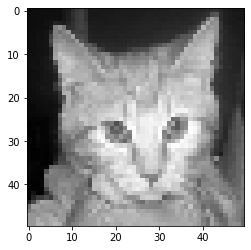

In [6]:
import matplotlib.pyplot as plt
plt.imshow(td[2][0], cmap="gray")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim=1) # print(x.shape) to put the value in self.fc1()
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        

In [9]:
net = Net()
net.forward(torch.randn(1, 1, 50, 50)) 

tensor([[0.5194, 0.4806]], grad_fn=<SoftmaxBackward0>)

In [10]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss = nn.MSELoss()

X = torch.Tensor([i[0] for i in td]).view(-1, 50, 50)
X = X/255.0 # rescaling image

y = torch.Tensor([i[1] for i in td])

val_percent = 0.1
val_size = int(len(X)*0.1)

/tmp/ipykernel_120961/1490855746.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  X = torch.Tensor([i[0] for i in td]).view(-1, 50, 50)


In [11]:
train_x = X[:-val_size]
train_y = y[:-val_size]

test_x = X[-val_size:]
test_y  = y[-val_size:]

In [12]:
len(train_y)

11229

In [13]:
BATCH_SIZE = 100
EPOCHS = 7

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}")
    for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
        batch_x = train_x[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i+BATCH_SIZE]
        net.zero_grad()
        outputs = net(batch_x)
        loss_ = loss(outputs, batch_y)
        loss_.backward()
        optimizer.step()
    

Epoch: 0


100%|█████████████████████████████████████████| 113/113 [00:14<00:00,  7.76it/s]


Epoch: 1


100%|█████████████████████████████████████████| 113/113 [00:11<00:00,  9.71it/s]


Epoch: 2


100%|█████████████████████████████████████████| 113/113 [00:13<00:00,  8.65it/s]


Epoch: 3


100%|█████████████████████████████████████████| 113/113 [00:13<00:00,  8.39it/s]


Epoch: 4


100%|█████████████████████████████████████████| 113/113 [00:14<00:00,  7.83it/s]


Epoch: 5


100%|█████████████████████████████████████████| 113/113 [00:13<00:00,  8.45it/s]


Epoch: 6


100%|█████████████████████████████████████████| 113/113 [00:12<00:00,  9.05it/s]


In [14]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_x[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        
        total += 1
        
print(f"Accuracy : {round(correct/total, 2)}")

100%|█████████████████████████████████████| 1247/1247 [00:00<00:00, 1424.77it/s]

Accuracy : 1.0


In [26]:
correct = 0
total = 0
import os
files = os.listdir('PetImages/Dog')
for i in files:
    img = cv2.imread(f'PetImages/Dog/{i}')
    try:
        img = cv2.resize(img, (50, 50))
        # img = np.array(img)
        img = torch.Tensor(img)
        with torch.no_grad():
            net_out = net(img.view(-1, 1, 50, 50))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == 0:
                # print("Cat")
                correct += 1
            total += 1
    except:
        pass
print(correct)
print(total)

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


1365
12470


In [20]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss_ = loss(outputs, y)
    if train:
        loss_.backward()
        optimizer.step()
    
    return acc, loss_

In [21]:
def test(size=32):
    random_start = np.random.randint(len(test_x)-size)
    X, y = test_x[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
      val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
    return val_acc, val_loss

In [28]:
val_acc, val_loss = test()
print(val_acc, val_loss)

1.0 tensor(0.)
